In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict

import matplotlib.pylab as plt
import seaborn as sns

import datetime
import random
from tqdm import tqdm
import itertools

import networkx as nx
import queue

## Data

In [2]:
df = pd.read_csv('wikigraph_reduced.csv')

In [3]:
df = df['\t0\t1'].str.split('\t', n=2, expand = True)
df.rename(columns={0: "edge",1: "source", 2: "target"}, inplace = True)
df.head(10)

,edge,source,target
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222
5,1143,134,1061485
6,1146,134,1163610
7,1147,134,1163783
8,1309,153,744272
9,1311,153,1064807


In [4]:
pages = pd.read_csv('wiki-topcats-page-names.txt', header = None, names = ['page'])
pages = pages['page'].str.split(' ', n=1, expand = True)
pages.drop(0,axis=1, inplace = True)
pages.rename(columns={1:'pageName'},inplace=True)

In [5]:
pages.head()

,pageName
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem


In [6]:
file = open("wiki-topcats-categories.txt", "r")
contents = file.read()
contents = contents.split("\n")
file.close()

## Initial Anlysis

In [7]:
#dictionary that has for keys the category and for value the list of pages in that category
dictionary_cat = {}

for i in tqdm(range(len(contents))):
    
    temp = contents[i].split(";")    
    if len(temp)>1:
    
        key = temp[0]
        key = key[9::]
        key

        list_page_frcat = temp[1].split(" ")
        list_page_frcat = list_page_frcat[1::]
        list_page_frcat

        dictionary_cat[key] = list_page_frcat

100%|██████████| 17365/17365 [00:00<00:00, 29200.63it/s]


In [8]:
len(dictionary_cat)

17364

From this dictionary we need to remove first the categories that have less than 5000 and more than 30000 pages associated

In [9]:
categories_to_drop = []
for key, value in dictionary_cat.items():
    if len(value)<5000 or len(value)>30000:
        categories_to_drop.append(key)

In [10]:
len(categories_to_drop)

17343

In [11]:
#create a new dictionary by including only the categories that are not in the list categories_to_drop
dictionary_cat = {i:dictionary_cat[i] for i in dictionary_cat if i not in categories_to_drop}

In [12]:
len(dictionary_cat)

21

In [13]:
dictionary_cat.keys()

dict_keys(['English_footballers', 'The_Football_League_players', 'Association_football_forwards', 'Association_football_midfielders', 'Association_football_defenders', 'Harvard_University_alumni', 'Major_League_Baseball_pitchers', 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 'Indian_films', 'Year_of_death_missing', 'Rivers_of_Romania', 'Main_Belt_asteroids', 'Asteroids_named_for_people', 'English-language_films', 'American_films', 'American_television_actors', 'American_film_actors', 'Debut_albums', 'Black-and-white_films', 'Year_of_birth_missing', 'Place_of_birth_missing_(living_people)'])

In [14]:
for key,value in dictionary_cat.items():
    print(f'{key}: {len(value)}')

English_footballers: 9237
The_Football_League_players: 9467
Association_football_forwards: 6959
Association_football_midfielders: 8270
Association_football_defenders: 6668
Harvard_University_alumni: 6154
Major_League_Baseball_pitchers: 6580
Members_of_the_United_Kingdom_Parliament_for_English_constituencies: 6546
Indian_films: 5913
Year_of_death_missing: 7851
Rivers_of_Romania: 7729
Main_Belt_asteroids: 13704
Asteroids_named_for_people: 5701
English-language_films: 22699
American_films: 15302
American_television_actors: 11661
American_film_actors: 13938
Debut_albums: 8401
Black-and-white_films: 12174
Year_of_birth_missing: 7237
Place_of_birth_missing_(living_people): 6767


In [15]:
#dictionary that associates to each page, the list of categories that is in
inverted_link = {}

for key,value in tqdm(dictionary_cat.items()):
    if value != None:

        for elem in value: 
            if elem not in inverted_link.keys():             
                inverted_link[elem] = []
                inverted_link[elem].append(key)

            else:
                inverted_link[elem].append(key)

100%|██████████| 21/21 [00:00<00:00, 179.77it/s]


In [16]:
#list that has all the pages that have are associated to more than 1 category
key_list = []
for key in inverted_link.keys():
    if len(inverted_link[key])>1:
        key_list.append(key)
print(f'number of pages that appear in more than one category: {len(key_list)}')

number of pages that appear in more than one category: 41555


In [17]:
inverted_link["22860"]

['English_footballers', 'Association_football_defenders']

In [18]:
#dictionary that shows the distribution of the pages in each category
len_list = {}

for key in key_list:     
    lenght = len(inverted_link[key]) 
    
    if lenght not in len_list.keys():             
                len_list[lenght] = 1
    else:
        len_list[lenght] += 1

In [19]:
len_list

{2: 34371, 3: 6783, 4: 378, 5: 22, 6: 1}

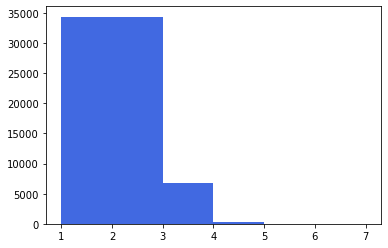

In [20]:
plt.bar(len_list.keys(), len_list.values(), width = 2.0, color='royalblue')
plt.xlim = (0, max(len_list.keys()))

For every page in the inverted index (key) I uniformly choose at random the category in which belongs and I create a new dictionary where the categories are the keys and the pages in each category are the values.

In [21]:
#final dictionary where the pages that appear in multiple categories are assigned to only one uniformly at random
final_category_dict = dict.fromkeys(dictionary_cat.keys())

for key,value in tqdm(inverted_link.items()):
    category = str(*np.random.choice(value, size=1, replace=False, p= None))
    if final_category_dict[category] == None:
        final_category_dict[category] = [key]
    else:
        final_category_dict[category].append(key)    

100%|██████████| 149794/149794 [00:02<00:00, 53153.96it/s]


#### Trial to see if the above operation worked

In [22]:
#dictionary that associates to each page, the list of categories that it is in
inverted_link2 = {}

for key,value in tqdm(final_category_dict.items()):
    if value != None:

        for elem in value: 
            if elem not in inverted_link2.keys():             
                inverted_link2[elem] = []
                inverted_link2[elem].append(key)

            else:
                inverted_link2[elem].append(key)

100%|██████████| 21/21 [00:00<00:00, 49.83it/s]


In [23]:
key_list = []
for key in inverted_link2.keys():
    if len(inverted_link2[key])>1:
        key_list.append(key)
key_list

[]

This proves that now there are no pages that appear in multiple categories

# Creating the graph 

In [24]:
'''l1 = [*df['target'].unique()]  #unique values from column target
l2 = [*df['source'].unique()]  #unique values from column source
l3 = list(set([*l1, *l2]))     #unique nodes to consider in the graph
len(l3)'''

"l1 = [*df['target'].unique()]  #unique values from column target\nl2 = [*df['source'].unique()]  #unique values from column source\nl3 = list(set([*l1, *l2]))     #unique nodes to consider in the graph\nlen(l3)"

In [25]:
'''G = nx.MultiDiGraph()
G.add_nodes_from(l3)
G.add_weighted_edges_from([df.iloc[i] for i in range(len(df))],weight = 1 )'''

'G = nx.MultiDiGraph()\nG.add_nodes_from(l3)\nG.add_weighted_edges_from([df.iloc[i] for i in range(len(df))],weight = 1 )'

In [26]:
# create the graph
G = nx.from_pandas_edgelist(df, "source", "target",create_using=nx.MultiDiGraph())

*Is this the correct graph?* 

We can visualize all the edges of the graph by the command `G.edges()`, however since this will generate a long list we just check some examples.

In [27]:
df.iloc[900]

edge      688634
source     41914
target    633362
Name: 900, dtype: object

In [28]:
G['41914']

AdjacencyView({'633362': {0: {}}})

In [29]:
print(df.iloc[1456],'\n')
print(df.iloc[1457])

edge      1193155
source      65522
target      35186
Name: 1456, dtype: object 

edge      1193161
source      65522
target      64932
Name: 1457, dtype: object


In [30]:
G['65522'] # this node has multiple target values 

AdjacencyView({'35186': {0: {}}, '64932': {0: {}}, '65074': {0: {}}})

From the section **General Notes** on point 2. we read: 'We assume that all edges in the graphs we will consider have weight equal to 1'. Therefore we add this weight to each edge of the graph. 

In [31]:
for e in G.edges():
    G[e[0]][e[1]]['weight'] = 1

TypeError: 'AtlasView' object does not support item assignment

# Answering the questions

**Is the graph directed?**

Yes, since the edges that compose the graph are ordered pairs of the form $(a,b)$. These pairs represent a hyperlink *from* the article $a$ *to* the article $b$. 

<font color='red'>find example of couple doesn't have reverse</font>

**How many articles are we considering?**

Every node in the graph represents a wikipedia article. Therefore: 

In [32]:
len(G) # this returns the number of nodes in the graph 

98343

**How many hyperlinks between pages exist?**

Every edge in the graph represents a hyperlink between articles. Therefore:

In [33]:
G.number_of_edges() # this returns the number of edges in the graph 

483094

*Notice that in counting hyperlinks the order of the pairs is important: $(a,b)$ and $(b,a)$ will count as $2$ hyperlinks.*

**Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?**

For the first part of the question, the answer is given by the formula: $\frac{|E|}{|V|}$ 
(where $|E|$ is the number of edges and $|V|$ is the number of vertices)

In [34]:
G.number_of_edges() / len(G)

4.912337431235573

For the second part of the question is important to understand what we mean by *graph density*. 

We will define *graph density* as the ratio between the number of edges and the maximum number of possible edges. In order to calculate what is the maximum number of edges of a graph, we need to understand what type of graph we are dealing with. 
`G` is a directed multigraph, therefore the set of all edges is $U := \{(x,y) \, \,  | \, \, (x,y) \in V^2: x \neq y\}$, therefore: $|U| = |V| \cdot |V-1|$ .

The density of the graph `G` is:

In [35]:
G.number_of_edges() / ( len(G)*(len(G)-1) )

4.9951571365597335e-05

<font color='red'>This might be parse?</font>

**Visualize the nodes' degree distribution**

In [ ]:
# p_k histograms 

### Some final cleaning
We need to clean one last time the categories file: we should consider only the nodes given in the reduced version of the graph. Therefore we are checking and removing the other ones and based on that.

In [36]:
nodes_to_consider=set(G.nodes())
len(nodes_to_consider)

98343

In [37]:
len(final_category_dict['English_footballers'])

5070

In [38]:
categories_to_drop = []
for key, value in final_category_dict.items():
    final_category_dict[key] = [values for values in value if values in nodes_to_consider]
    if len(final_category_dict[key])<5000:
        categories_to_drop.append(key)

In [39]:
len([values for values in final_category_dict['English_footballers'] if values in nodes_to_consider])

3610

In [40]:
for key,value in final_category_dict.items():
    print(f'{key}: {len(value)}')

English_footballers: 3610
The_Football_League_players: 3616
Association_football_forwards: 2525
Association_football_midfielders: 2771
Association_football_defenders: 2115
Harvard_University_alumni: 2970
Major_League_Baseball_pitchers: 3307
Members_of_the_United_Kingdom_Parliament_for_English_constituencies: 6431
Indian_films: 2742
Year_of_death_missing: 1398
Rivers_of_Romania: 7662
Main_Belt_asteroids: 8697
Asteroids_named_for_people: 2301
English-language_films: 13292
American_films: 7525
American_television_actors: 6414
American_film_actors: 9161
Debut_albums: 2553
Black-and-white_films: 5252
Year_of_birth_missing: 1472
Place_of_birth_missing_(living_people): 2529


### RQ2. Function 1

Define a function that takes in input:

- A page *v*
- A number of clicks *d*

and returns the set of all pages that a user can reach within *d* clicks.

### RQ3. Function 2

Define a function that takes in input:

- A category *C*
- A set of pages in *C*, *p = {p1, ..., pn}*

and returns the minimum number of clicks required to reach all pages in *p*, starting from the page *v*, corresponding to the most central article, according to the *in-degree* centrality, in *C*.

---
Our interpretation of the problem consists of finding the maximum number of clicks needed to get from the selected central page v, to the furthest page away in terms of clicks. To solve this problem we worked with the neighbors of each page in the graph.

Starting from page v our idea was to look at all the neighbors of v in the directed graph. From the list of neighbors generated we distinguished from the pages that belonged to the category in input and those who didn't. The first ones were all the pages that could be reached in 1 click from v, the second ones were stored because they could create a path to reach other pages in the category.

In the second iteration we looked at the neighbors of all the pages found in iteration 1. Again we divided the pages into those who belonged to the category (that are now all the pages that can be reached in 2 clicks starting from v), and those who didn't.

We repeated the process in a recursive way until the function returned an empty list of pages inside the category reached in that iteration. At this point, if the total number of pages of the category reached by our function was equal to the effective number of pages in the category, the function would return the number of iteration where it stopped, that is exactly the minimun number of clicks needed to reacha all pages $p$, starting from page $v$. If, on the other hand, the total was smaller, the function would just return 'NOT POSSIBLE' because it didn't find any path to get from page $v$ to all the pages of the category

In [ ]:
#in-degree(v): number of edges entering in v

def most_central_article(df, pages, final_category_dict, category):
    set_pages = final_category_dict[category] #set of pages corresponding to the category in input
    
    in_degrees = []
    for page in set_pages:  #for every page in set_pages
        
        #counts how many links are pointing to that page 
        in_degrees.append(df.loc[df['target']==page]['edge'].count())
    
    most_central = set_pages[in_degrees.index(max(in_degrees))]
    
    return most_central

In [ ]:
#already implemented 
category = category = input('choose a category: ')

subG = G.subgraph(final_category_dict[category])
in_degrees = nx.in_degree_centrality(subG)

m = max(in_degrees.values())
for key, value in in_degrees.items():
    if value == m:
        v = key

print(f'The starting node is: {v}')

In [ ]:
#our implementation
category = input('choose a category: ')
v = most_central_article(df, pages, final_category_dict, category)
print(f'The starting node is: {v}')

In [ ]:
def iterations(set_pages, G, pages_reached, tot_pages_reached):
    set_pages = list(list(set(set_pages)-set(pages_reached)) + list(set(pages_reached)-set(set_pages)))
    pages_reached1 = []
    for p in pages_reached:
        try:
            pages_reached1.append([n for n in G.neighbors(p) if n in set_pages and n not in tot_pages_reached])
        except nx.exception.NetworkXError:
            pass
    
    pages_reached1 = set(list(itertools.chain.from_iterable(pages_reached1)))
    tot_pages_reached += list(pages_reached1)
    
    return pages_reached1, tot_pages_reached


In [ ]:
def min_clicks(G, df, pages, final_category_dict,v,category):
    i = 0 
    set_pages = final_category_dict[category]  
    pages_reached = [n for n in G.neighbors(v) if n in set_pages]
    tot_pages_reached = pages_reached
    
    print(f'Iteration {i}. Pages reached in {i} click: {len(pages_reached)}')
    
    while len(pages_reached) != 0:
        i += 1
        pages_reached, tot_pages_reached = iterations(set_pages, G, pages_reached, tot_pages_reached)
        print(f'Iteration {i}. Pages reached in {i} click: {len(pages_reached)}')
        
    if len(tot_pages_reached) == len(final_category_dict[category]):
        return f'minimum number of clicks required to reach all pages: {i+1}'
    
    else:
        return i, f'Not Possible, total pages reached: {len(tot_pages_reached)} out of {len(final_category_dict[category])}'

In [ ]:
print(min_clicks(G, df, pages, final_category_dict,v,category))

In [ ]:
for category in final_category_dict.keys():
    print(category)
    v = most_central_article(df, pages, final_category_dict, category)
    print(min_clicks(G, df, pages, final_category_dict,v,category))
    print('\n')

#### Different version that considers all the pages as neighbours, not only those pages that are in the list of pages of the category in input.


Il metodo è molto molto più lento e in realtà la condizione per stoppare il while non è corretta perchè potrebbe essere che in una iterazione non trova nessuna pagina della categoria, ma dalle pagine trovate poi si ricollega all'iterazione successiva ad una pagina della categoria. In questo caso il sottografo indotto dalle pagine della cateogria non è connesso ma le pagine sono lo stesso raggiungibili attraverso nodi intermedi

In [ ]:
'''This function checks, every time it is recalled, the neighbors of the page in input. It also differentiate between 
the pages that have to be reached, that are in the list of pages of the category in input, and the pages that 
are useful only to create a path but are not in the category of interest.
In output returns:
- the pages in the category of interest reached in that iteration
- the pages not in the category of interest reached in that iteration
- the updated list of pages visited, both from the category and not
- the updated list of pages visited ONLY of the category of interest'''

def iterations(set_pages, G, pages_reached_in_setpages, pages_reached_not_in_set, tot_pages_reached, tot_pages_only_set):
    set_pages = list(list(set(set_pages)-set(pages_reached_in_setpages)) + list(set(pages_reached_in_setpages)-set(set_pages)))
    pages_reached_in_setpages1 = []   #neighbors that are in the set of pages to reach
    pages_reached_not_in_set1 = []    #all other neighbors
    
    tot = pages_reached_in_setpages +  pages_reached_not_in_set
    #for every page find the list of neighbors and differentiate between those in the category and those who are not
    for p in tot:
        neighbors = [n for n in G.neighbors(p)]
        try:
            pages_reached_in_setpages1.append([n for n in neighbors if n in set_pages and n not in tot_pages_reached])
            pages_reached_not_in_set1.append([n for n in neighbors if n not in set_pages and n not in tot_pages_reached])
        
        except nx.exception.NetworkXError:
            pass
    
    #combine all neighbors of all pages into one list
    pages_reached_in_setpages1 = list(set(list(itertools.chain.from_iterable(pages_reached_in_setpages1))))
    pages_reached_not_in_set1 = list(set(list(itertools.chain.from_iterable(pages_reached_not_in_set1))))
    
    #update the list of visited pages
    tot_pages_reached += pages_reached_in_setpages1 + pages_reached_not_in_set1
    tot_pages_only_set += pages_reached_in_setpages1
    
    return pages_reached_in_setpages1, pages_reached_not_in_set1, tot_pages_reached, tot_pages_only_set

In [ ]:
'''Function that takes in input:
- the graph G
- the original dataframe with the information about the edges df
- the dictionary that has for keys the category and for values the list of pages in that category
- the starting page v
- the cateogry chosen in input by the user

The output is the minimum number of clicks needed to get from the central page v to the page that is further away from it
- I have to click to the max number of links to get there. If I cannot get to ALL the pages in the category from my initial
page, the algorithm stops and return the max number of pages it got before it had to stop'''

def min_clicks(G, df, pages, final_category_dict,v,category):
    i = 0 
    set_pages = final_category_dict[category]                                           #set of all pages from the category in input
    
    neighbors = [n for n in G.neighbors(v)]                                             #all the neighbors of node v
    pages_reached_in_setpages = [n for n in neighbors if n in set_pages]                #neighbors that are in the set of pages to reach
    pages_reached_not_in_set = list(set(neighbors) - set(pages_reached_in_setpages))    #all other neighbors
    
    tot_pages_reached = pages_reached_in_setpages + pages_reached_not_in_set            #tot pages already reached 
    tot_pages_only_set = pages_reached_in_setpages                                      #pages inside the category already reached
    
    print(f'Iteration {i}. Pages reached in {i+1} click: {len(pages_reached_in_setpages)}')
    
    while len(pages_reached_in_setpages) != 0:
        i += 1
        pages_reached_in_setpages, pages_reached_not_in_set, tot_pages_reached, tot_pages_only_set = iterations(set_pages, G, pages_reached_in_setpages, 
                                                                                                                pages_reached_not_in_set, tot_pages_reached,
                                                                                                                tot_pages_only_set)
        print(f'Iteration {i}. Pages reached in {i+1} click: {len(pages_reached_in_setpages)}')
        
    if len(tot_pages_reached) == len(final_category_dict[category]):                    #if I visit all the pages in the category
        return f'minimum number of clicks required to reach all pages: {i+1}'           #I return the maximum number of clicks to reach the page that is further than v
    
    #if the sum is not equal it means that there is at least one page that cannot be reached from v
    else:
        return i, f'Not Possible, total pages reached: {len(tot_pages_only_set)} out of {len(final_category_dict[category])}'

In [ ]:
#in-degree built-in 
category = category = input('choose a category: ')

subG = G.subgraph(final_category_dict[category])
in_degrees = nx.in_degree_centrality(subG)

m = max(in_degrees.values())
for key, value in in_degrees.items():
    if value == m:
        v = key

print(f'The starting node is: {v} \n')
print(min_clicks(G, df, pages, final_category_dict,v,category))

In [ ]:
for category in final_category_dict.keys():
    print(category)
    
    subG = G.subgraph(final_category_dict[category])
    in_degrees = nx.in_degree_centrality(subG)

    m = max(in_degrees.values())
    for key, value in in_degrees.items():
        if value == m:
            v = key

    print(min_clicks(G, df, pages, final_category_dict,v,category))
    print('\n')

### RQ4. Induced Subgraph

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

- Let *v* and *u* two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect *u* and *v*?

### RQ5. Function 3

Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as  $distance(C0, Ci) = median(ShortestPath(C0, Ci))$ 

Where $ShortestPath(C0, Ci)$ is the set of shortest paths from each pair of nodes in the two categories.

### RQ6. Function 4

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm

We define the pagerank of a category as the sum of the pageranks of all the pages in that category, and the final output will return the category ordered in descending order based on this score.
In order to apply the pagerank algorithm we need to assing to each edge a weight, which corresponds to the probability that a random surfer will follow a specific link starting from a random page. To assign these probabilities we need to look at each node, and from it, at all the edges exiting that node. The weight associated to the link going from node $i$ to node $j$ will then just be $w_{ij}  = \frac{1}{\textrm{#outlinks}(i)}$. 

As a first thing we are going to define a new dictionary `outlinks_per_node` that has for keys the nodes names and for values the number of outlinks that the node has:

In [41]:
outlinks_per_node = defaultdict()
for node in tqdm(G.nodes()):
    outlinks_per_node[node] = len(G[node])

100%|██████████| 98343/98343 [00:00<00:00, 569595.34it/s]


In [ ]:
#dictionary that has for keys the nodes names and for values the number of incoming links in that node
'''inlinks_per_node = defaultdict()
indegrees = G.in_degree(G.nodes()) #list of tuples with 1st element id of the node and 2nd element in-degree
for tup in indegrees:
    inlinks_per_node[tup[0]] = tup[1]''' 

Then we will use it to assign a weight to each edge, using the formula described above. The list of weight will then be added as a new column in the original dataframe `df`

In [42]:
weight = []
for row in tqdm(df.iterrows()):
    weight.append(round(1/outlinks_per_node[row[1][1]], 3))

483094it [00:36, 13138.74it/s]


In [43]:
#I create a new dataframe from df that has also the weight column
df1 = df.copy()
df1['weight'] = weight
df1.head()

,edge,source,target,weight
0,796,95,1185516,1.000
1,909,108,1059989,0.333
2,910,108,1062426,0.333
3,911,108,1161925,0.333
4,1141,134,541222,0.250


The new dataframe will be used to generate a new multidirected graph that assignes to each edge an attribute, given by the column **weight** of the dataframe

In [44]:
G1 = nx.from_pandas_edgelist(df1, "source", "target",create_using=nx.MultiDiGraph(), edge_attr = 'weight')

Now we will implement the algorithm for the pagerank. To do so, we need to define a series a functions. The first step is to create the transition matrix where each row and each column refers to a node. The values in the matrix correspons to the probability to go from one node to the other, given by the weight that we have already computed

In [45]:
M = np.zeros((len(G1.nodes()), len(G1.nodes())))  #initialize a matrix nxn (n = #nodes)
nodes = [node for node in G1.nodes()]             #list of nodes in our graph

#for each row that corresponds to each node
for i,source in tqdm(enumerate(G1.nodes())):
    nodes_linked = [elem for elem in G1[source]]   #list of nodes that can be reached from that node
    for target in nodes_linked:
        M[i][nodes.index(target)] = G1[source][target][0]['weight']  #I assign the weight that I previously calculated
                                                                     #in the correct cell of the matrix

98343it [07:57, 205.86it/s] 


Since the values are probabilities, each row must sum to 1. There is one case where this is not true: when there are no outgoings link from one node. In this case, all the values of the corresponding row are going to be 0. To fix this case we will substitute each zero to $\frac{1}{n}$ where $n$ is the number of nodes in the graph

In [46]:
#to detect the rows of the matrix that sum to 0 instead of 1 we can use the dictionary that we have created before,
#the row will sum to zero only if there are no outgoing links from it
count = 0 
zero_outlinks = []
for key, value in outlinks_per_node.items():
    if value == 0:
        count +=1
        zero_outlinks.append(str(key))
print(count)

7423


In [47]:
#now we will change only the rows of the matrix that sum to 0 to sum = 1
n = len(nodes)
for elem in tqdm(zero_outlinks):
    M[nodes.index(elem)] = 1/n

100%|██████████| 7423/7423 [00:15<00:00, 485.50it/s] 


In [49]:
def pagerank(n_iter, a, nodes, M):
    n = len(M)               #number of nodes
    m_id = np.ones((n, n))   #matrix n*n with all ones 

    P = (1/n)*a*m_id + (1-a)*M              #probability to get to one node to the other
 
    starting_page = random.choice(nodes)    #select a random page where to start random
    v = np.zeros((1,len(nodes)))         
    v[0][nodes.index(starting_page)] = 1.0  #create a strating vector that has 1 only in the position of the page selected

    for i in range(n_iter):                 #repeat the process 100 time 
        v = v @ P
        
    return v                                #the final vector v will contain the probbaility of being at page i
                                            #after all the iterations

In [ ]:
def order_categories(v, nodes, final_category_dict):
    pagerank = defaultdict()
    for category, list_of_pages in final_category_dict.items():
        pagerank[category] = sum([v[nodes.index[page]] for page in list_of_pages])
        
    sorted_dict = {key: v for key, value in sorted(pagerank.items(), key=lambda item: item[1])}
    
    return sorted_dict.keys()

In [ ]:
v = pagerank(100, 0.1, nodes, M)

In [ ]:
c = 0
for elem in v[0]:
    c+=elem
c   #perchè non fa 1?

In [ ]:
order_categories(v, nodes, final_category_dict)

## Prova con le prime 1000 righe

In [ ]:
df2 = df.iloc[:1000].copy()
df2

In [ ]:
n1 = list(df2.source.unique())
n2 = list(df2.target.unique())
nodes = list(set(n1 + n2))

In [ ]:
G2 = nx.from_pandas_edgelist(df2, "source", "target",create_using=nx.MultiDiGraph())

In [ ]:
outlinks_per_node2 = defaultdict()
for node in tqdm(nodes):
    outlinks_per_node2[node] = len(G2[node])
    
weight2 = []
for row in tqdm(df2.iterrows()):
    weight2.append(round(1/outlinks_per_node2[row[1][1]], 3))
    
df2['weight'] = weight2
df2.head()

In [ ]:
G2 = nx.from_pandas_edgelist(df2, "source", "target",create_using=nx.MultiDiGraph(), edge_attr = 'weight')

Now that we have created the new graph we can implement on it the pagerank algorithm. The idea behind the pagerank algorithm based on the random-surfer is that, starting from a random page, a user will follow a direct link to another page with probability equal to the weight that we associated to each node, OR it will visit a random page (not following a link) with:       
$$\textrm{probability} = \frac{1}{\textrm{total number of nodes in the graph}}$$

In [ ]:
#prova con le prime 1000 righe
M = np.zeros((len(nodes),len(nodes)))
n = len(M)

for i,source in tqdm(enumerate(nodes)):
    nodes_linked = [elem for elem in G2[source]]
    
    if len(nodes_linked)!=0:
        for target in nodes_linked:
            M[i][nodes.index(target)] = G2[source][target][0]['weight'] 
    
    if round(sum(M[i]),1) == 0.0:
        M[i] = 1/n 

In [ ]:
v = pagerank(100, 0.15, nodes, M)
v

In [ ]:
c = 0
for elem in v[0]:
    c+=elem
c   #perchè non fa 1?